# Electric Vehicle Charging Demand Forecasting

### Importing Libraries

In [1]:
from meteostat import Point, Hourly
import pandas as pd
from datetime import datetime
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns

### Loading The Dataset

In [2]:
# EV dataset based in California, Palo Alto
ev = pd.read_csv("EVcharging.csv")
ev

,timestamp,Station Name,MAC Address,Org Name,Start Date,Start Time Zone,End Date,End Time Zone,Transaction Date (Pacific Time),Total Duration (hh:mm:ss),...,Currency,Fee,Ended By,Plug In Event Id,Driver Postal Code,User ID,County,System S/N,Model Number,timestamp_hourly
0,01-01-2018 10:36,PALO ALTO CA / CAMBRIDGE #1,0024:B100:0002:1329,City of Palo Alto,01-01-2018 01:49,PST,01-01-2018 10:34,PST,01-01-2018 10:36,0 days 08:45:22,...,USD,11.88,Plug Out at Vehicle,6179,94306,801989,Santa Clara County,1.427410e+11,CT4020-HD-GW,01-01-2018 10:00
1,01-01-2018 12:02,PALO ALTO CA / HIGH #1,0024:B100:0002:1262,City of Palo Alto,01-01-2018 08:33,PST,01-01-2018 12:01,PST,01-01-2018 12:02,0 days 03:27:58,...,USD,4.20,Customer,26,94301,855278,Santa Clara County,1.425410e+11,CT4020-HD-GW,01-01-2018 12:00
2,01-01-2018 09:21,PALO ALTO CA / MPL #6,000D:6F00:015B:7509,City of Palo Alto,01-01-2018 09:00,PST,01-01-2018 09:21,PST,01-01-2018 09:21,0 days 00:20:33,...,USD,0.45,Plug Out at Vehicle,5910,94306,623575,San Mateo County,1.147100e+11,CT2000-HD-CCR,01-01-2018 09:00
3,01-01-2018 10:58,PALO ALTO CA / CAMBRIDGE #2,0024:B100:0002:13B7,City of Palo Alto,01-01-2018 09:38,PST,01-01-2018 10:57,PST,01-01-2018 10:58,0 days 01:18:40,...,USD,0.67,Plug Out at Vehicle,5833,94306,779957,Santa Clara County,1.428410e+11,CT4020-HD-GW,01-01-2018 10:00
4,01-01-2018 12:26,PALO ALTO CA / BRYANT #6,0024:B100:0002:6B43,City of Palo Alto,01-01-2018 09:52,PST,01-01-2018 12:26,PST,01-01-2018 12:26,0 days 02:33:52,...,USD,3.61,Plug Out at Vehicle,972,95014,704951,Santa Clara County,1.705410e+11,CT4020-HD-GW,01-01-2018 12:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102776,30-12-2020 16:40,PALO ALTO CA / BRYANT #4,0024:B100:0002:6D37,City of Palo Alto,30-12-2020 14:58,PST,30-12-2020 16:39,PST,30-12-2020 16:40,0 days 01:41:16,...,USD,2.23,Plug Out at Vehicle,3461,94301,546163,Santa Clara County,1.707410e+11,CT4020-HD,30-12-2020 16:00
102777,30-12-2020 20:09,PALO ALTO CA / BRYANT #6,0024:B100:0002:6B43,City of Palo Alto,30-12-2020 15:09,PST,30-12-2020 20:09,PST,30-12-2020 20:09,0 days 04:59:14,...,USD,4.56,Plug Out at Vehicle,1609369787,94301,20283051,Santa Clara County,1.705410e+11,CT4020-HD-GW,30-12-2020 20:00
102778,30-12-2020 21:40,PALO ALTO CA / WEBSTER #1,0024:B100:0002:4233,City of Palo Alto,30-12-2020 17:07,PST,30-12-2020 21:39,PST,30-12-2020 21:40,0 days 04:31:36,...,USD,6.28,Plug Out at Vehicle,7252,94301,2653661,Santa Clara County,1.336410e+11,CT4020-HD-GW,30-12-2020 21:00
102779,30-12-2020 19:20,PALO ALTO CA / CAMBRIDGE #5,0024:B100:0002:9B7F,City of Palo Alto,30-12-2020 18:34,PST,30-12-2020 19:20,PST,30-12-2020 19:20,0 days 00:45:54,...,USD,1.03,Plug Out at Vehicle,4670,94040,4463341,Santa Clara County,1.742410e+11,CT4020-HD,30-12-2020 19:00


In [3]:
# Traffic based in California around Palo Alto
traffic = pd.read_csv("traffic.csv", index_col=0)
traffic

,EventId,Type,Severity,TMC,Description,StartTime(UTC),EndTime(UTC),TimeZone,LocationLat,LocationLng,Distance(mi),AirportCode,Number,Street,Side,City,County,State,ZipCode
0,T-27485994,Congestion,1,73,Delays increasing and delays of two minutes on...,2018-01-01 08:18:00,2018-01-01 09:09:48,US/Pacific,37.583172,-122.327492,1.75,KSFO,NaN,Bayshore Fwy S,R,San Mateo,San Mateo,CA,94401.0
1,T-27486005,Congestion,1,75,Delays of two minutes on Bayshore Fwy Southbou...,2018-01-01 09:22:00,2018-01-01 10:04:51,US/Pacific,37.578091,-122.321968,4.19,KSFO,NaN,Bayshore Fwy S,R,San Mateo,San Mateo,CA,94401.0
2,T-27486029,Accident,2,201,Accident on US-101 Northbound at Norfolk St.,2018-01-01 15:39:20,2018-01-01 16:24:02,US/Pacific,37.553684,-122.296257,0.00,KSQL,NaN,US-101 N,R,San Mateo,San Mateo,CA,94403.0
3,T-27486032,Accident,3,201,Accident on I-280 Southbound at CA-92 Half Moo...,2018-01-01 16:44:13,2018-01-01 17:28:21,US/Pacific,37.509499,-122.333496,0.00,KSQL,NaN,CA-92 E,R,Belmont,San Mateo,CA,94002.0
4,T-27486035,Lane-Blocked,2,61,#2 lane blocked due to a mattress in the road ...,2018-01-01 17:31:03,2018-01-01 18:30:39,US/Pacific,37.549320,-122.292496,0.00,KSQL,NaN,Bayshore Fwy S,R,San Mateo,San Mateo,CA,94403.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116819,T-4988511,Congestion,0,72,Delays of two minutes and delays easing on CA-...,2020-12-31 22:09:00,2020-12-31 23:05:06,US/Pacific,37.482670,-122.230545,1.35,KSQL,1174.0,El Camino Real,R,Redwood City,San Mateo,CA,94063.0
116820,T-4988510,Congestion,0,72,Delays of three minutes and delays increasing ...,2020-12-31 22:15:00,2020-12-31 23:02:49,US/Pacific,37.368881,-122.036301,2.26,KNUQ,330.0,W El Camino Real,L,Sunnyvale,Santa Clara,CA,94087.0
116821,T-4988509,Congestion,0,72,Delays of two minutes and delays easing on Ste...,2020-12-31 22:19:00,2020-12-31 23:31:12,US/Pacific,37.323009,-122.021423,1.74,KNUQ,19917.0,Stevens Creek Blvd,L,Cupertino,Santa Clara,CA,95014.0
116822,T-4988677,Congestion,0,72,Delays of three minutes and delays easing on S...,2020-12-31 22:52:00,2020-12-31 23:52:57,US/Pacific,37.322880,-122.053581,2.07,KNUQ,21683.0,Stevens Creek Blvd,R,Cupertino,Santa Clara,CA,95014.0


In [4]:
# Weather dataset around California, Palo Alto from 2018-2020
palo_alto = Point(37.444572, -122.160309)

start = datetime(2018, 1, 1)
end = datetime(2020, 12, 31)

weather = Hourly(palo_alto, start, end)
weather = weather.fetch()
weather.to_csv("palo_alto_weather_2018_2020.csv")

weather

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2018-01-01 00:00:00,13.0,8.1,72.0,NaN,NaN,280.0,7.0,NaN,1018.5,NaN,5.0
2018-01-01 01:00:00,13.3,7.7,69.0,0.0,NaN,290.0,0.0,NaN,1019.3,NaN,NaN
2018-01-01 02:00:00,13.3,7.7,69.0,0.0,NaN,230.0,0.0,NaN,1020.0,NaN,5.0
2018-01-01 03:00:00,11.1,6.6,74.0,0.0,NaN,200.0,0.0,NaN,1020.6,NaN,5.0
2018-01-01 04:00:00,10.6,7.1,79.0,0.0,NaN,80.0,0.0,NaN,1021.0,NaN,5.0
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-30 20:00:00,11.1,1.6,52.0,0.0,NaN,330.0,9.4,NaN,1027.6,NaN,3.0
2020-12-30 21:00:00,12.8,4.0,55.0,0.0,NaN,320.0,7.6,NaN,1026.1,NaN,2.0
2020-12-30 22:00:00,13.3,3.4,51.0,0.0,NaN,330.0,11.2,NaN,1025.9,NaN,3.0


### Data Cleaning And Data Preprocessing

In [5]:
ev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102781 entries, 0 to 102780
Data columns (total 35 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   timestamp                        102781 non-null  object 
 1   Station Name                     102781 non-null  object 
 2   MAC Address                      102781 non-null  object 
 3   Org Name                         102781 non-null  object 
 4   Start Date                       102781 non-null  object 
 5   Start Time Zone                  102781 non-null  object 
 6   End Date                         102781 non-null  object 
 7   End Time Zone                    102781 non-null  object 
 8   Transaction Date (Pacific Time)  102781 non-null  object 
 9   Total Duration (hh:mm:ss)        102781 non-null  object 
 10  Charging Time (hh:mm:ss)         102781 non-null  object 
 11  Energy (kWh)                     102781 non-null  float64
 12  GH

In [6]:
ev.isnull().sum()

timestamp                          0
Station Name                       0
MAC Address                        0
Org Name                           0
Start Date                         0
Start Time Zone                    0
End Date                           0
End Time Zone                      0
Transaction Date (Pacific Time)    0
Total Duration (hh:mm:ss)          0
Charging Time (hh:mm:ss)           0
Energy (kWh)                       0
GHG Savings (kg)                   0
Gasoline Savings (gallons)         0
Port Type                          0
Port Number                        0
Plug Type                          0
EVSE ID                            0
Address 1                          0
City                               0
State/Province                     0
Postal Code                        0
Country                            0
Latitude                           0
Longitude                          0
Currency                           0
Fee                                0
E

In [7]:
ev = ev.dropna()

In [8]:
# Converting columns to appropriate datetime and timedelta types
ev = ev.copy()

ev['Start Date'] = pd.to_datetime(ev['Start Date'], errors='coerce')
ev['End Date'] = pd.to_datetime(ev['End Date'], errors='coerce')
ev['Transaction Date (Pacific Time)'] = pd.to_datetime(ev['Transaction Date (Pacific Time)'], errors='coerce')

ev['Total Duration (hh:mm:ss)'] = pd.to_timedelta(ev['Total Duration (hh:mm:ss)'], errors='coerce')
ev['Charging Time (hh:mm:ss)'] = pd.to_timedelta(ev['Charging Time (hh:mm:ss)'], errors='coerce')

In [9]:
weather.isna().sum()

temp        0
dwpt        0
rhum        0
prcp      193
snow    26281
wdir       29
wspd        0
wpgt    26281
pres        0
tsun    26281
coco     2980
dtype: int64

In [10]:
## Dropping irrelevant columns and filling missing values
weather.drop(columns=['snow', 'wpgt', 'tsun'], inplace=True)
weather['wdir'] = weather['wdir'].ffill() 
weather['coco'] = weather['coco'].ffill() 
weather['prcp'] = weather['prcp'].ffill().bfill()

In [11]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26281 entries, 2018-01-01 00:00:00 to 2020-12-31 00:00:00
Freq: h
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    26281 non-null  float64
 1   dwpt    26281 non-null  float64
 2   rhum    26281 non-null  float64
 3   prcp    26281 non-null  float64
 4   wdir    26281 non-null  float64
 5   wspd    26281 non-null  float64
 6   pres    26281 non-null  float64
 7   coco    26281 non-null  float64
dtypes: float64(8)
memory usage: 1.8 MB


In [12]:
# Creating hourly timestamp for EV dataset
ev['timestamp'] = ev['Transaction Date (Pacific Time)']
ev.set_index('timestamp', inplace=True)
ev['timestamp_hourly'] = ev.index.floor('h')

In [13]:
## Merging EV and weather datasets
ev_weather = pd.merge(ev, weather, left_on='timestamp_hourly', right_index=True, how='left')
ev_weather

,Station Name,MAC Address,Org Name,Start Date,Start Time Zone,End Date,End Time Zone,Transaction Date (Pacific Time),Total Duration (hh:mm:ss),Charging Time (hh:mm:ss),...,Model Number,timestamp_hourly,temp,dwpt,rhum,prcp,wdir,wspd,pres,coco
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 10:36:00,PALO ALTO CA / CAMBRIDGE #1,0024:B100:0002:1329,City of Palo Alto,2018-01-01 01:49:00,PST,2018-01-01 10:34:00,PST,2018-01-01 10:36:00,0 days 08:45:22,0 days 08:44:43,...,CT4020-HD-GW,2018-01-01 10:00:00,8.9,7.2,89.0,0.0,130.0,7.6,1023.1,5.0
2018-01-01 12:02:00,PALO ALTO CA / HIGH #1,0024:B100:0002:1262,City of Palo Alto,2018-01-01 08:33:00,PST,2018-01-01 12:01:00,PST,2018-01-01 12:02:00,0 days 03:27:58,0 days 02:23:58,...,CT4020-HD-GW,2018-01-01 12:00:00,7.2,6.1,93.0,0.0,140.0,0.0,1023.3,5.0
2018-01-01 09:21:00,PALO ALTO CA / MPL #6,000D:6F00:015B:7509,City of Palo Alto,2018-01-01 09:00:00,PST,2018-01-01 09:21:00,PST,2018-01-01 09:21:00,0 days 00:20:33,0 days 00:20:14,...,CT2000-HD-CCR,2018-01-01 09:00:00,9.4,7.2,86.0,0.0,150.0,5.4,1023.3,5.0
2018-01-01 10:58:00,PALO ALTO CA / CAMBRIDGE #2,0024:B100:0002:13B7,City of Palo Alto,2018-01-01 09:38:00,PST,2018-01-01 10:57:00,PST,2018-01-01 10:58:00,0 days 01:18:40,0 days 01:18:14,...,CT4020-HD-GW,2018-01-01 10:00:00,8.9,7.2,89.0,0.0,130.0,7.6,1023.1,5.0
2018-01-01 12:26:00,PALO ALTO CA / BRYANT #6,0024:B100:0002:6B43,City of Palo Alto,2018-01-01 09:52:00,PST,2018-01-01 12:26:00,PST,2018-01-01 12:26:00,0 days 02:33:52,0 days 02:31:53,...,CT4020-HD-GW,2018-01-01 12:00:00,7.2,6.1,93.0,0.0,140.0,0.0,1023.3,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaT,PALO ALTO CA / BRYANT #4,0024:B100:0002:6D37,City of Palo Alto,NaT,PST,NaT,PST,NaT,0 days 01:41:16,0 days 01:40:47,...,CT4020-HD,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaT,PALO ALTO CA / BRYANT #6,0024:B100:0002:6B43,City of Palo Alto,NaT,PST,NaT,PST,NaT,0 days 04:59:14,0 days 03:16:01,...,CT4020-HD-GW,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaT,PALO ALTO CA / WEBSTER #1,0024:B100:0002:4233,City of Palo Alto,NaT,PST,NaT,PST,NaT,0 days 04:31:36,0 days 04:31:21,...,CT4020-HD-GW,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
ev_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 102781 entries, 2018-01-01 10:36:00 to NaT
Data columns (total 42 columns):
 #   Column                           Non-Null Count   Dtype          
---  ------                           --------------   -----          
 0   Station Name                     102781 non-null  object         
 1   MAC Address                      102781 non-null  object         
 2   Org Name                         102781 non-null  object         
 3   Start Date                       40661 non-null   datetime64[ns] 
 4   Start Time Zone                  102781 non-null  object         
 5   End Date                         40683 non-null   datetime64[ns] 
 6   End Time Zone                    102781 non-null  object         
 7   Transaction Date (Pacific Time)  40526 non-null   datetime64[ns] 
 8   Total Duration (hh:mm:ss)        102781 non-null  timedelta64[ns]
 9   Charging Time (hh:mm:ss)         102781 non-null  timedelta64[ns]
 10  Energy (kWh)  

In [15]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 116824 entries, 0 to 116823
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   EventId         116824 non-null  object 
 1   Type            116824 non-null  object 
 2   Severity        116824 non-null  int64  
 3   TMC             116824 non-null  int64  
 4   Description     116824 non-null  object 
 5   StartTime(UTC)  116824 non-null  object 
 6   EndTime(UTC)    116824 non-null  object 
 7   TimeZone        116651 non-null  object 
 8   LocationLat     116824 non-null  float64
 9   LocationLng     116824 non-null  float64
 10  Distance(mi)    116824 non-null  float64
 11  AirportCode     116651 non-null  object 
 12  Number          30459 non-null   float64
 13  Street          116824 non-null  object 
 14  Side            116824 non-null  object 
 15  City            116824 non-null  object 
 16  County          116824 non-null  object 
 17  State          

In [16]:
traffic['StartTime(UTC)'] = pd.to_datetime(traffic['StartTime(UTC)'])
traffic['EndTime(UTC)'] = pd.to_datetime(traffic['EndTime(UTC)'])
traffic['ZipCode'] = traffic['ZipCode'].astype('Int64').astype('str')

In [17]:
## Aligning timestamp formats for merging
ev_weather['hour'] = ev_weather['timestamp_hourly'].dt.floor('h')
traffic['hour'] = traffic['StartTime(UTC)'].dt.floor('h')

In [18]:
## Merging EV-weather and traffic datasets
ev_weather_traffic = pd.merge(ev_weather, traffic, on='hour', how='inner')
ev_weather_traffic

,Station Name,MAC Address,Org Name,Start Date,Start Time Zone,End Date,End Time Zone,Transaction Date (Pacific Time),Total Duration (hh:mm:ss),Charging Time (hh:mm:ss),...,LocationLng,Distance(mi),AirportCode,Number,Street,Side,City_y,County_y,State,ZipCode
0,PALO ALTO CA / MPL #6,000D:6F00:015B:7509,City of Palo Alto,2018-01-01 09:00:00,PST,2018-01-01 09:21:00,PST,2018-01-01 09:21:00,0 days 00:20:33,0 days 00:20:14,...,-122.321968,4.19,KSFO,NaN,Bayshore Fwy S,R,San Mateo,San Mateo,CA,94401
1,PALO ALTO CA / HIGH #1,0024:B100:0002:1262,City of Palo Alto,2018-01-01 10:58:00,PST,2018-01-01 17:34:00,PST,2018-01-01 17:36:00,0 days 06:35:24,0 days 05:16:21,...,-122.292496,0.00,KSQL,NaN,Bayshore Fwy S,R,San Mateo,San Mateo,CA,94403
2,PALO ALTO CA / RINCONADA LIB 3,000D:6F00:015A:96E4,City of Palo Alto,2018-01-01 11:35:00,PST,2018-01-01 13:09:00,PST,2018-01-01 15:27:00,0 days 01:33:42,0 days 01:33:35,...,-122.296257,0.00,KSQL,NaN,US-101 N,R,San Mateo,San Mateo,CA,94403
3,PALO ALTO CA / WEBSTER #1,0024:B100:0002:4233,City of Palo Alto,2018-01-01 11:38:00,PST,2018-01-01 15:32:00,PST,2018-01-01 15:33:00,0 days 03:54:18,0 days 01:58:57,...,-122.296257,0.00,KSQL,NaN,US-101 N,R,San Mateo,San Mateo,CA,94403
4,PALO ALTO CA / MPL #5,000D:6F00:0154:FFC5,City of Palo Alto,2018-01-01 12:00:00,PST,2018-01-01 16:46:00,PST,2018-01-01 16:48:00,0 days 04:46:38,0 days 04:33:46,...,-122.333496,0.00,KSQL,NaN,CA-92 E,R,Belmont,San Mateo,CA,94002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195593,PALO ALTO CA / WEBSTER #3,0024:B100:0002:4277,City of Palo Alto,2020-12-12 18:21:00,PST,2020-12-12 21:40:00,PST,2020-12-12 21:40:00,0 days 03:18:58,0 days 03:05:35,...,-122.179794,0.93,KPAO,NaN,Roble Ave,R,Menlo Park,San Mateo,CA,94025
195594,PALO ALTO CA / WEBSTER #3,0024:B100:0002:4277,City of Palo Alto,2020-12-12 18:21:00,PST,2020-12-12 21:40:00,PST,2020-12-12 21:40:00,0 days 03:18:58,0 days 03:05:35,...,-122.230545,1.35,KSQL,1174.0,El Camino Real,R,Redwood City,San Mateo,CA,94063
195595,PALO ALTO CA / WEBSTER #3,0024:B100:0002:4277,City of Palo Alto,2020-12-12 18:21:00,PST,2020-12-12 21:40:00,PST,2020-12-12 21:40:00,0 days 03:18:58,0 days 03:05:35,...,-122.000824,1.80,KNUQ,NaN,Calvert Dr,R,Cupertino,Santa Clara,CA,95014
195596,PALO ALTO CA / WEBSTER #3,0024:B100:0002:4277,City of Palo Alto,2020-12-12 18:21:00,PST,2020-12-12 21:40:00,PST,2020-12-12 21:40:00,0 days 03:18:58,0 days 03:05:35,...,-122.027557,2.30,KNUQ,NaN,Stevens Creek Blvd,R,Cupertino,Santa Clara,CA,95014


In [19]:
columns = {
    'Station Name': 'station_name',
    'timestamp_hourly': 'timestamp',
    'Total Duration (hh:mm:ss)': 'total_duration',
    'Charging Time (hh:mm:ss)': 'charging_time',
    'Energy (kWh)': 'energy_kwh',
    'Fee': 'charging_fee',
    'GHG Savings (kg)': 'ghg_savings',
    'Gasoline Savings (gallons)': 'gasoline_savings',
    'Port Type': 'port_type',
    'Port Number': 'port_number',
    'Plug Type': 'plug_type',
    'Latitude': 'latitude',
    'Longitude': 'longitude',
    'Postal Code': 'postal_code',
    'City_x': 'city',
    'County_x': 'county',
    'State': 'state',
    'temp': 'temperature',
    'dwpt': 'dew_point',
    'rhum': 'humidity',
    'prcp': 'precipitation',
    'wdir': 'wind_direction',
    'wspd': 'wind_speed',
    'pres': 'pressure',
    'Type': 'traffic_type',
    'Severity': 'traffic_severity',
    'Distance(mi)': 'traffic_distance',
    'TMC': 'traffic_message_code'
}

df = ev_weather_traffic[list(columns)].rename(columns=columns)
df

,station_name,timestamp,total_duration,charging_time,energy_kwh,charging_fee,ghg_savings,gasoline_savings,port_type,port_number,...,dew_point,humidity,precipitation,wind_direction,wind_speed,pressure,traffic_type,traffic_severity,traffic_distance,traffic_message_code
0,PALO ALTO CA / MPL #6,2018-01-01 09:00:00,0 days 00:20:33,0 days 00:20:14,1.977,0.45,0.830,0.248,Level 2,1,...,7.2,86.0,0.0,150.0,5.4,1023.3,Congestion,1,4.19,75
1,PALO ALTO CA / HIGH #1,2018-01-01 17:00:00,0 days 06:35:24,0 days 05:16:21,17.586,5.38,7.386,2.207,Level 2,1,...,7.2,93.0,0.0,160.0,0.0,1024.5,Lane-Blocked,2,0.00,61
2,PALO ALTO CA / RINCONADA LIB 3,2018-01-01 15:00:00,0 days 01:33:42,0 days 01:33:35,9.474,2.18,3.979,1.189,Level 2,2,...,5.0,100.0,0.0,200.0,0.0,1024.2,Accident,2,0.00,201
3,PALO ALTO CA / WEBSTER #1,2018-01-01 15:00:00,0 days 03:54:18,0 days 01:58:57,6.101,4.04,2.563,0.766,Level 2,2,...,5.0,100.0,0.0,200.0,0.0,1024.2,Accident,2,0.00,201
4,PALO ALTO CA / MPL #5,2018-01-01 16:00:00,0 days 04:46:38,0 days 04:33:46,14.705,3.38,6.176,1.846,Level 2,1,...,5.7,97.0,0.0,80.0,0.0,1024.1,Accident,3,0.00,201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195593,PALO ALTO CA / WEBSTER #3,2020-12-12 21:00:00,0 days 03:18:58,0 days 03:05:35,9.412,2.16,3.953,1.181,Level 2,2,...,9.4,72.0,0.0,290.0,18.4,1019.9,Congestion,0,0.93,72
195594,PALO ALTO CA / WEBSTER #3,2020-12-12 21:00:00,0 days 03:18:58,0 days 03:05:35,9.412,2.16,3.953,1.181,Level 2,2,...,9.4,72.0,0.0,290.0,18.4,1019.9,Congestion,0,1.35,72
195595,PALO ALTO CA / WEBSTER #3,2020-12-12 21:00:00,0 days 03:18:58,0 days 03:05:35,9.412,2.16,3.953,1.181,Level 2,2,...,9.4,72.0,0.0,290.0,18.4,1019.9,Congestion,0,1.80,72
195596,PALO ALTO CA / WEBSTER #3,2020-12-12 21:00:00,0 days 03:18:58,0 days 03:05:35,9.412,2.16,3.953,1.181,Level 2,2,...,9.4,72.0,0.0,290.0,18.4,1019.9,Congestion,0,2.30,72


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195598 entries, 0 to 195597
Data columns (total 28 columns):
 #   Column                Non-Null Count   Dtype          
---  ------                --------------   -----          
 0   station_name          195598 non-null  object         
 1   timestamp             195598 non-null  datetime64[ns] 
 2   total_duration        195598 non-null  timedelta64[ns]
 3   charging_time         195598 non-null  timedelta64[ns]
 4   energy_kwh            195598 non-null  float64        
 5   charging_fee          195598 non-null  float64        
 6   ghg_savings           195598 non-null  float64        
 7   gasoline_savings      195598 non-null  float64        
 8   port_type             195598 non-null  object         
 9   port_number           195598 non-null  int64          
 10  plug_type             195598 non-null  object         
 11  latitude              195598 non-null  float64        
 12  longitude             195598 non-null  float

In [21]:
## Fixing timestamp format of final dataset for Forecasting model
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d-%m-%Y %H:%M')

### Exploratory Data Analysis

In [22]:
df.describe()

,timestamp,total_duration,charging_time,energy_kwh,charging_fee,ghg_savings,gasoline_savings,port_number,latitude,longitude,...,temperature,dew_point,humidity,precipitation,wind_direction,wind_speed,pressure,traffic_severity,traffic_distance,traffic_message_code
count,195598,195598,195598,195598.000000,195598.000000,195598.000000,195598.000000,195598.000000,195598.000000,195598.000000,...,195598.000000,195598.000000,195598.000000,195598.000000,195598.000000,195598.000000,195598.000000,195598.000000,195598.000000,195598.000000
mean,2019-04-17 07:29:16.674403584,0 days 02:17:09.410975572,0 days 01:57:57.567025225,9.091496,2.319256,3.818428,1.140983,1.531902,37.439055,-122.151916,...,15.367030,8.962797,69.131775,0.037921,200.291670,6.983716,1016.682709,1.168488,3.123139,137.107920
min,2018-01-01 09:00:00,0 days 00:01:00,0 days 00:00:13,0.010000,0.000000,0.004000,0.001000,1.000000,37.422104,-122.163239,...,1.700000,-13.400000,9.000000,0.000000,0.000000,0.000000,998.000000,0.000000,0.000000,28.000000
25%,2018-09-11 09:00:00,0 days 01:09:12,0 days 01:02:20,4.091000,1.010000,1.718000,0.513000,1.000000,37.426228,-122.162231,...,11.700000,6.200000,58.000000,0.000000,130.000000,0.000000,1014.000000,1.000000,1.000000,72.000000
50%,2019-05-07 14:00:00,0 days 02:00:58,0 days 01:47:57,6.986000,1.750000,2.934000,0.877000,2.000000,37.444489,-122.158272,...,15.000000,9.900000,74.000000,0.000000,180.000000,5.400000,1016.400000,1.000000,2.570000,74.000000
75%,2019-10-08 15:00:00,0 days 02:59:54,0 days 02:35:09,12.134000,3.050000,5.096000,1.523000,2.000000,37.446667,-122.146011,...,18.300000,12.700000,83.000000,0.000000,320.000000,9.400000,1018.800000,2.000000,3.900000,76.000000
max,2020-12-12 21:00:00,1 days 08:39:35,0 days 17:27:24,68.283000,62.080000,28.679000,8.569000,2.000000,37.448284,-122.112480,...,39.400000,17.800000,100.000000,7.100000,360.000000,53.600000,1035.500000,4.000000,53.310001,1804.000000
std,NaN,0 days 01:41:47.230144103,0 days 01:19:56.221084712,7.489480,2.089212,3.145588,0.939930,0.498982,0.009728,0.014256,...,5.532128,4.753484,18.736238,0.258109,117.424412,7.119546,4.124029,0.812930,3.409803,167.218303


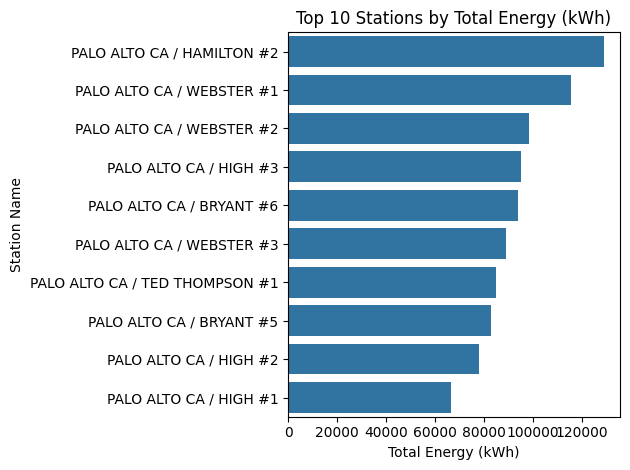

In [23]:
## Top 10 stations by total energy delivered
top_stations = df.groupby('station_name')['energy_kwh'].sum().sort_values(ascending=False).head(10)
sns.barplot(x=top_stations.values, y=top_stations.index)
plt.title('Top 10 Stations by Total Energy (kWh)')
plt.xlabel('Total Energy (kWh)')
plt.ylabel('Station Name')
plt.tight_layout()
plt.show()

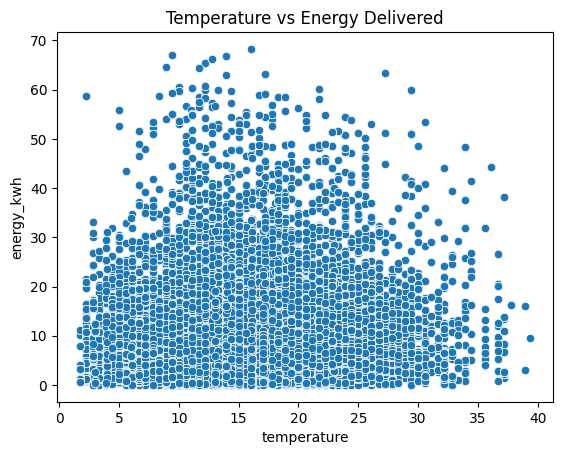

In [24]:
## Scatter plot: Temperature vs Energy delivered
sns.scatterplot(data=df, x='temperature', y='energy_kwh')
plt.title('Temperature vs Energy Delivered')
plt.show()

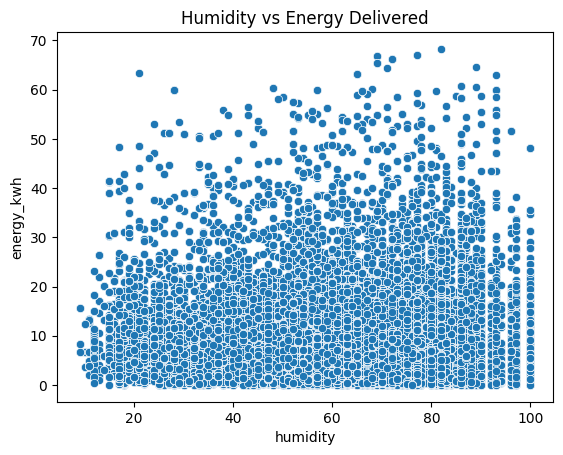

In [25]:
# Scatter plot: Humidity vs Energy delivered
sns.scatterplot(data=df, x='humidity', y='energy_kwh')
plt.title('Humidity vs Energy Delivered')
plt.show()

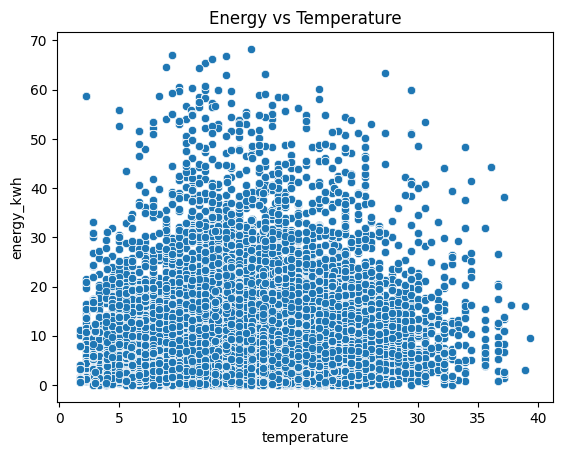

In [26]:
# Scatter plot: Energy vs Temperature
sns.scatterplot(data=df, x='temperature', y='energy_kwh')
plt.title('Energy vs Temperature')
plt.show()

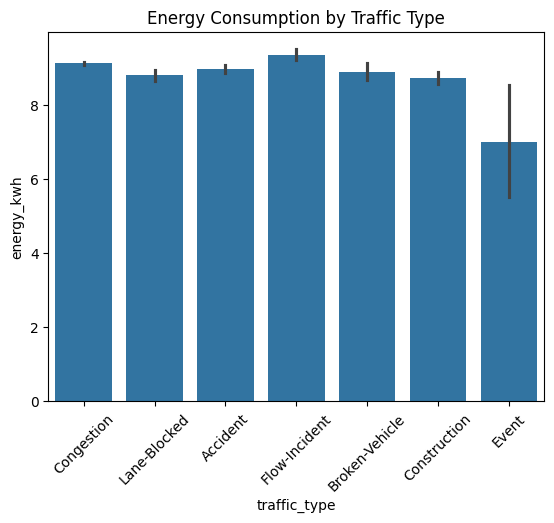

In [27]:
# Bar plot: Energy consumption by traffic type
sns.barplot(x='traffic_type', y='energy_kwh', data=df)
plt.xticks(rotation=45)
plt.title('Energy Consumption by Traffic Type')
plt.show()

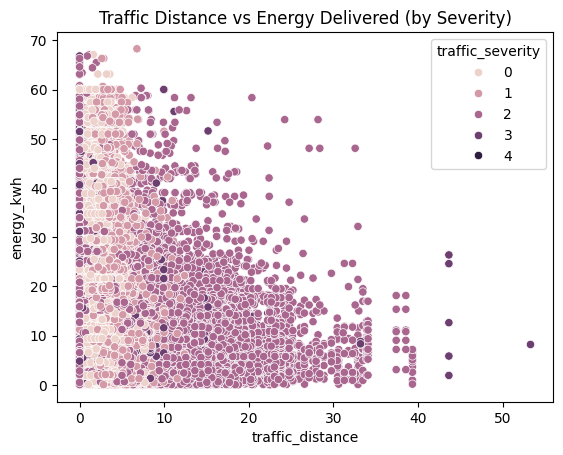

In [28]:
# Scatter plot: Traffic distance vs Energy delivered by severity
sns.scatterplot(x='traffic_distance', y='energy_kwh', hue='traffic_severity', data=df)
plt.title('Traffic Distance vs Energy Delivered (by Severity)')
plt.show()

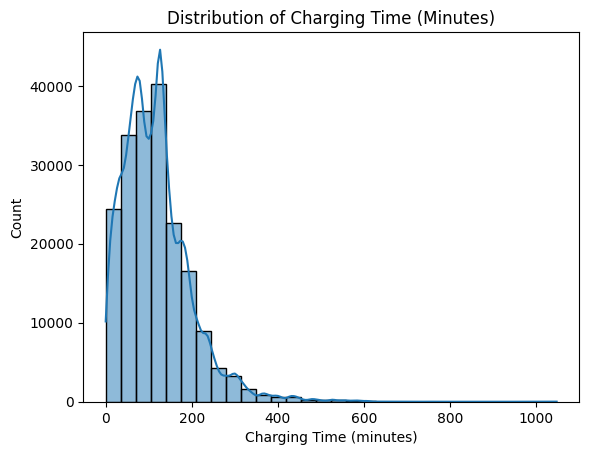

In [29]:
# Distribution of charging time
df['charging_seconds'] = pd.to_timedelta(df['charging_time']).dt.total_seconds()
sns.histplot(df['charging_seconds']/60, bins=30, kde=True)
plt.title('Distribution of Charging Time (Minutes)')
plt.xlabel('Charging Time (minutes)')
plt.show()

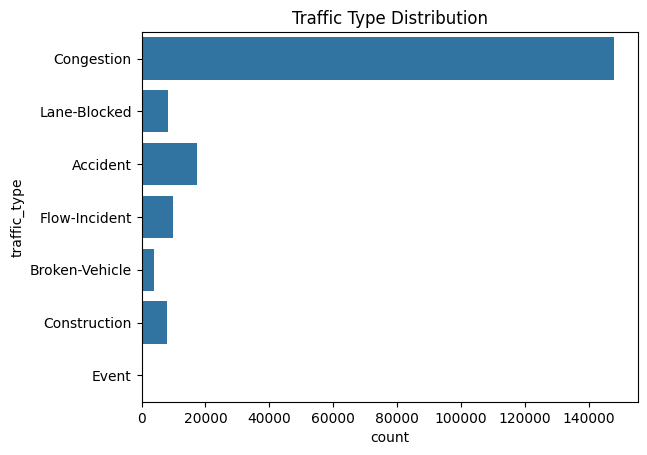

In [30]:
# Count plot: Traffic type distribution
sns.countplot(data=df, y='traffic_type')
plt.title('Traffic Type Distribution')
plt.show()

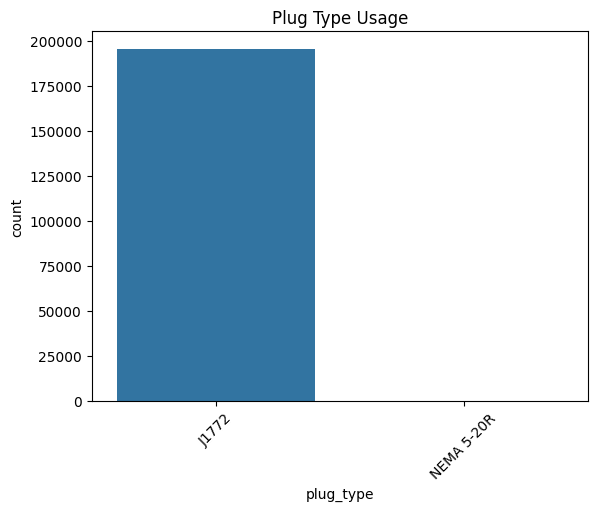

In [31]:
# Count plot: Plug type usage
sns.countplot(data=df, x='plug_type')
plt.title('Plug Type Usage')
plt.xticks(rotation=45)
plt.show()

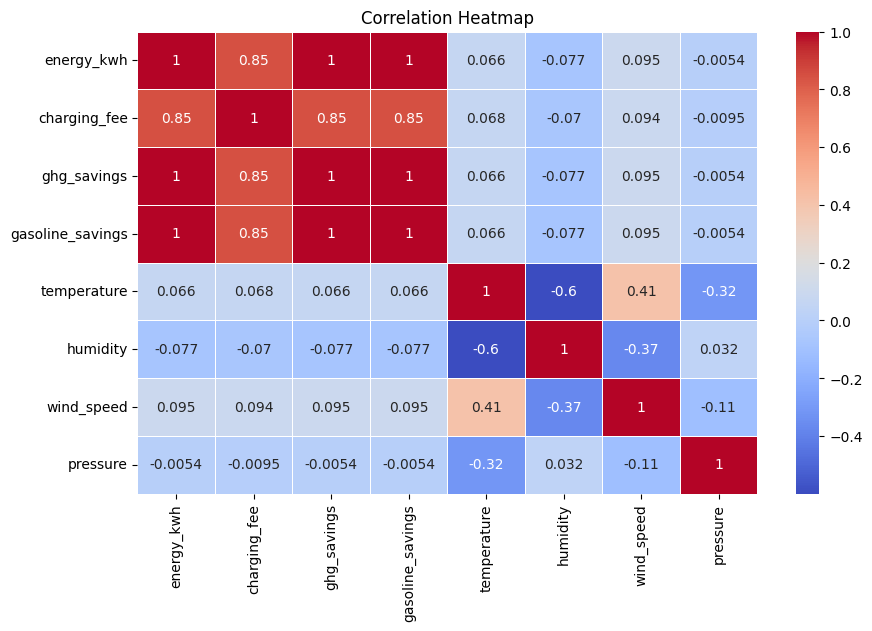

In [32]:
# Correlation heatmap
corr = df[['energy_kwh', 'charging_fee', 'ghg_savings', 'gasoline_savings',
           'temperature', 'humidity', 'wind_speed', 'pressure']].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

### Time Series Forecasting

In [33]:
# Preparing for Time series model
data = df[['timestamp', 'energy_kwh']].rename(columns={'timestamp': 'ds', 'energy_kwh': 'y'})
data

,ds,y
0,2018-01-01 09:00:00,1.977
1,2018-01-01 17:00:00,17.586
2,2018-01-01 15:00:00,9.474
3,2018-01-01 15:00:00,6.101
4,2018-01-01 16:00:00,14.705
...,...,...
195593,2020-12-12 21:00:00,9.412
195594,2020-12-12 21:00:00,9.412
195595,2020-12-12 21:00:00,9.412
195596,2020-12-12 21:00:00,9.412


In [34]:
# Fitting Prophet model
model = Prophet()
model.fit(data)

20:50:30 - cmdstanpy - INFO - Chain [1] start processing
20:51:43 - cmdstanpy - INFO - Chain [1] done processing


In [50]:
# Forecasting energy for the next day
future_day = model.make_future_dataframe(periods=24, freq='h')
forecast_day = model.predict(future_day)
forecast_day[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv('forecast_day.csv', index=False)
forecast_day[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
4625,2020-12-13 17:00:00,9.907204,0.032621,19.490583
4626,2020-12-13 18:00:00,9.433269,0.667424,18.920556
4627,2020-12-13 19:00:00,9.148255,-0.817572,18.656654
4628,2020-12-13 20:00:00,9.721957,0.165204,18.867888
4629,2020-12-13 21:00:00,11.300007,1.452521,20.384070


In [51]:
# Forecasting energy for the next week
future_week = model.make_future_dataframe(periods=168, freq='h')
forecast_week = model.predict(future_week)
forecast_week[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv('forecast_week.csv', index=False)
forecast_week[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
4769,2020-12-19 17:00:00,10.419447,1.613766,20.343818
4770,2020-12-19 18:00:00,9.969799,0.471668,19.463735
4771,2020-12-19 19:00:00,9.707627,-0.064667,19.208671
4772,2020-12-19 20:00:00,10.302566,1.361922,19.133259
4773,2020-12-19 21:00:00,11.900117,1.973212,21.392130


In [52]:
# Forecasting energy for the next month
future_month = model.make_future_dataframe(periods=720, freq='h')
forecast_month = model.predict(future_month)
forecast_month[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv('forecast_month.csv', index=False)
forecast_month[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
5321,2021-01-11 17:00:00,12.207452,3.303544,20.862888
5322,2021-01-11 18:00:00,11.739732,2.239449,21.172378
5323,2021-01-11 19:00:00,11.460315,1.550660,20.706925
5324,2021-01-11 20:00:00,12.038839,2.680363,21.555843
5325,2021-01-11 21:00:00,13.620795,4.069920,22.896423


In [53]:
# Forecasting energy for the next 3 months
future_3months = model.make_future_dataframe(periods=2160, freq='h')
forecast_3months = model.predict(future_3months)
forecast_3months[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv('forecast_3months.csv', index=False)
forecast_3months[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
6761,2021-03-12 17:00:00,11.404201,2.322507,20.857157
6762,2021-03-12 18:00:00,10.939418,1.091905,20.162519
6763,2021-03-12 19:00:00,10.665081,1.518450,20.407124
6764,2021-03-12 20:00:00,11.250866,2.359955,21.128176
6765,2021-03-12 21:00:00,12.842281,3.128983,22.025939


In [54]:
# Forecasting energy for the next 6 months
future_6months = model.make_future_dataframe(periods=4320, freq='h')
forecast_6months = model.predict(future_6months)
forecast_6months[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv('forecast_6months.csv', index=False)
forecast_6months[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
8921,2021-06-10 17:00:00,11.068206,2.523065,21.002534
8922,2021-06-10 18:00:00,10.589432,0.463998,20.646079
8923,2021-06-10 19:00:00,10.298124,1.005950,20.103883
8924,2021-06-10 20:00:00,10.864126,1.769409,20.821887
8925,2021-06-10 21:00:00,12.433142,3.054608,22.446483


In [49]:
# Forecasting energy for the next year
future_year = model.make_future_dataframe(periods=8760, freq='h')
forecast_year = model.predict(future_year)
forecast_year[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv('forecast_year.csv', index=False)
forecast_year[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
13361,2021-12-12 17:00:00,10.791470,0.846880,21.173374
13362,2021-12-12 18:00:00,10.316645,-0.166251,19.346362
13363,2021-12-12 19:00:00,10.030741,0.489145,19.575143
13364,2021-12-12 20:00:00,10.603553,0.807971,21.360909
13365,2021-12-12 21:00:00,12.180714,2.485699,21.912527


In [56]:
# Updated helper function to summarize yhat, yhat_lower, yhat_upper
def summarize_forecast_full(forecast_df, period_name):
    print(f"--- {period_name} Forecast Summary ---")
    
    # yhat (predicted)
    print(f"[yhat] Max: {forecast_df['yhat'].max():.2f} | Min: {forecast_df['yhat'].min():.2f} | Avg: {forecast_df['yhat'].mean():.2f}")
    
    # yhat_lower (lower bound)
    print(f"[yhat_lower] Max: {forecast_df['yhat_lower'].max():.2f} | Min: {forecast_df['yhat_lower'].min():.2f} | Avg: {forecast_df['yhat_lower'].mean():.2f}")
    
    # yhat_upper (upper bound)
    print(f"[yhat_upper] Max: {forecast_df['yhat_upper'].max():.2f} | Min: {forecast_df['yhat_upper'].min():.2f} | Avg: {forecast_df['yhat_upper'].mean():.2f}")
    
    print("\n")

# Now run this for each forecast

summarize_forecast_full(forecast_day, "Next Day")
summarize_forecast_full(forecast_week, "Next Week")
summarize_forecast_full(forecast_month, "Next Month")
summarize_forecast_full(forecast_3months, "Next 3 Months")
summarize_forecast_full(forecast_6months, "Next 6 Months")
summarize_forecast_full(forecast_year, "Next Year")

--- Next Day Forecast Summary ---
[yhat] Max: 16.95 | Min: 6.44 | Avg: 9.72
[yhat_lower] Max: 8.09 | Min: -3.52 | Avg: 0.34
[yhat_upper] Max: 26.48 | Min: 15.16 | Avg: 19.10


--- Next Week Forecast Summary ---
[yhat] Max: 16.95 | Min: 6.44 | Avg: 9.77
[yhat_lower] Max: 8.00 | Min: -3.44 | Avg: 0.40
[yhat_upper] Max: 26.57 | Min: 15.07 | Avg: 19.14


--- Next Month Forecast Summary ---
[yhat] Max: 18.02 | Min: 6.44 | Avg: 10.13
[yhat_lower] Max: 8.94 | Min: -3.44 | Avg: 0.76
[yhat_upper] Max: 28.14 | Min: 15.32 | Avg: 19.51


--- Next 3 Months Forecast Summary ---
[yhat] Max: 18.02 | Min: 6.44 | Avg: 10.69
[yhat_lower] Max: 8.97 | Min: -3.37 | Avg: 1.32
[yhat_upper] Max: 27.78 | Min: 15.05 | Avg: 20.06


--- Next 6 Months Forecast Summary ---
[yhat] Max: 18.02 | Min: 6.44 | Avg: 11.16
[yhat_lower] Max: 9.26 | Min: -3.68 | Avg: 1.79
[yhat_upper] Max: 28.24 | Min: 15.42 | Avg: 20.56


--- Next Year Forecast Summary ---
[yhat] Max: 18.02 | Min: 6.44 | Avg: 11.65
[yhat_lower] Max: 9.38 | M

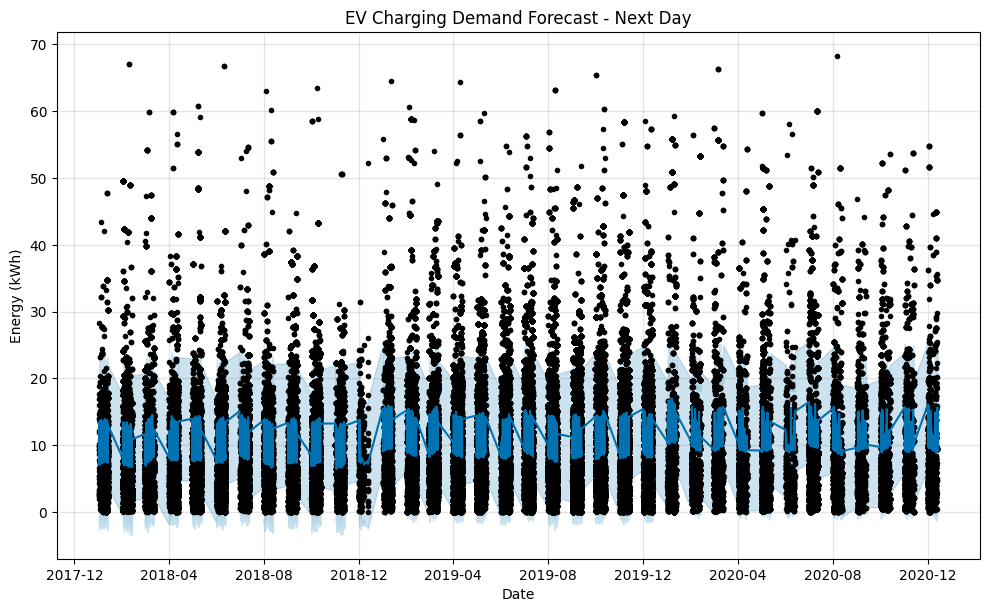

In [41]:
model.plot(forecast_day)
plt.title('EV Charging Demand Forecast - Next Day')
plt.xlabel('Date')
plt.ylabel('Energy (kWh)')
plt.show()

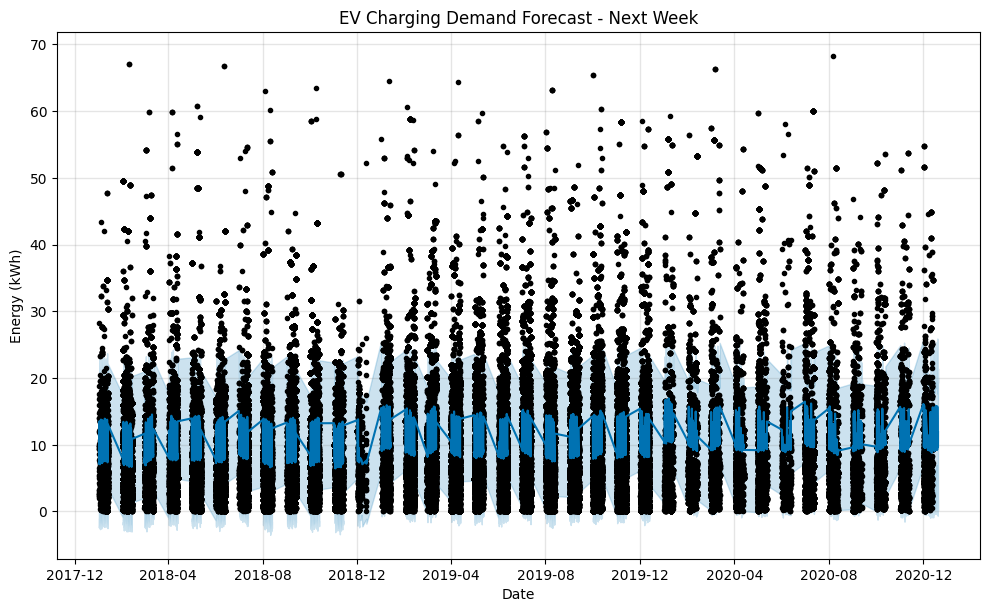

In [42]:
model.plot(forecast_week)
plt.title('EV Charging Demand Forecast - Next Week')
plt.xlabel('Date')
plt.ylabel('Energy (kWh)')
plt.show()

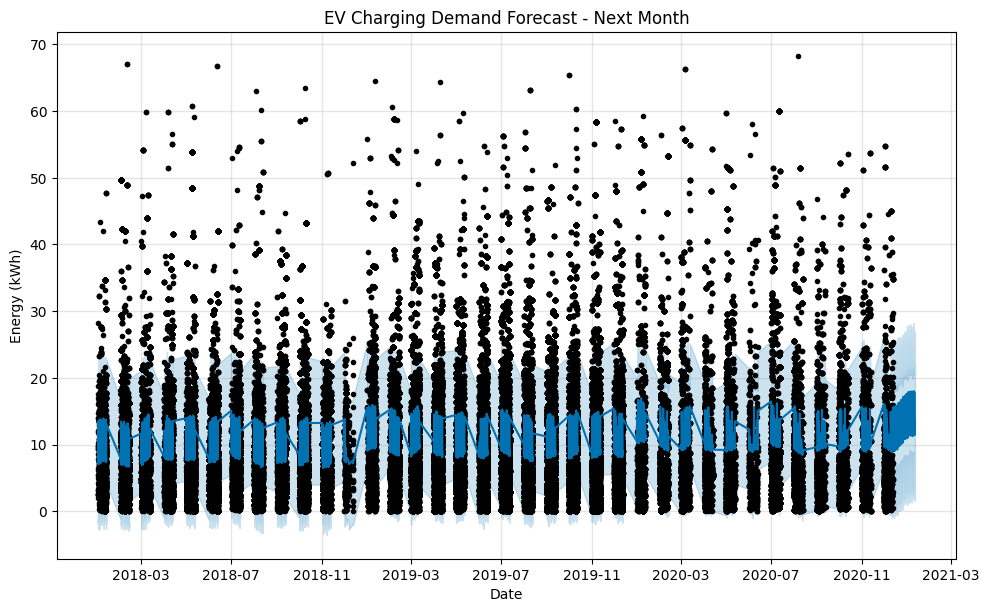

In [43]:
model.plot(forecast_month)
plt.title('EV Charging Demand Forecast - Next Month')
plt.xlabel('Date')
plt.ylabel('Energy (kWh)')
plt.show()

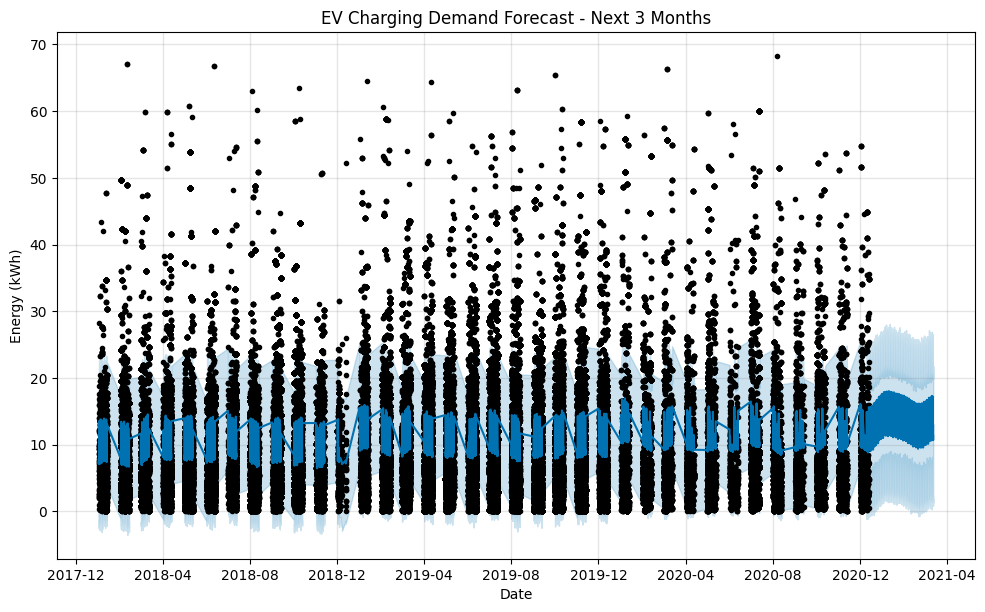

In [44]:
model.plot(forecast_3months)
plt.title('EV Charging Demand Forecast - Next 3 Months')
plt.xlabel('Date')
plt.ylabel('Energy (kWh)')
plt.show()

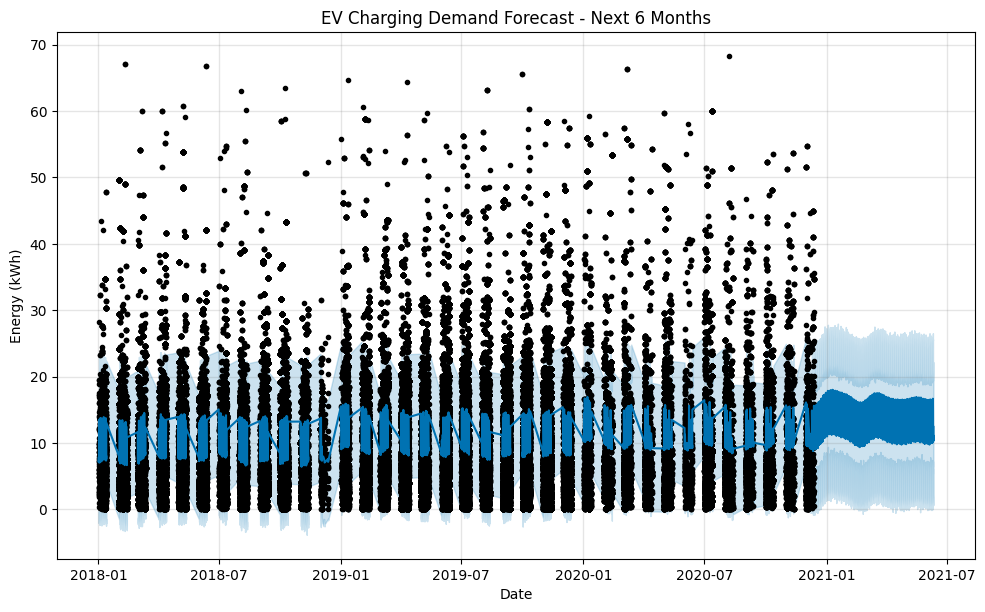

In [45]:
model.plot(forecast_6months)
plt.title('EV Charging Demand Forecast - Next 6 Months')
plt.xlabel('Date')
plt.ylabel('Energy (kWh)')
plt.show()

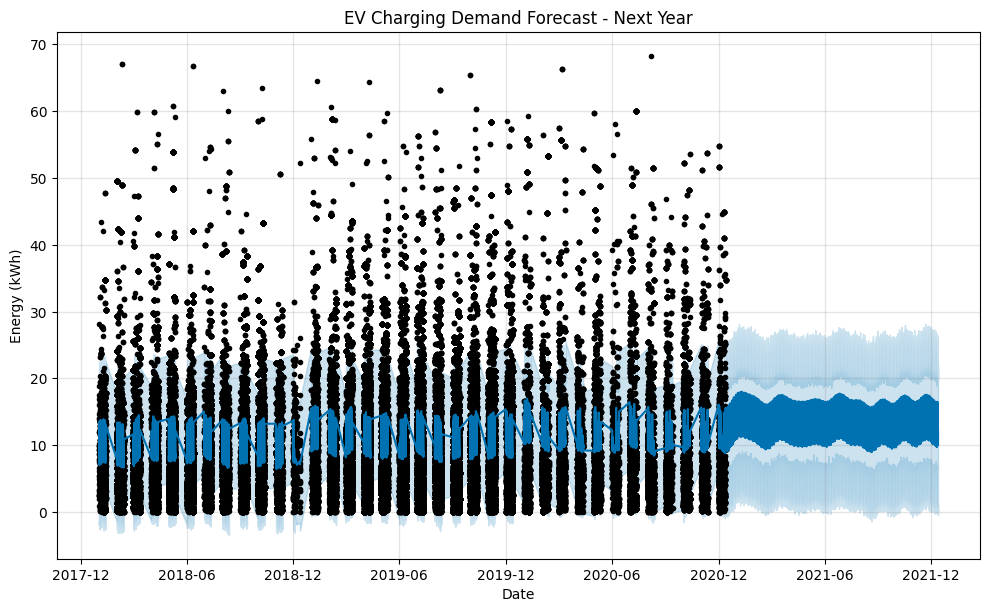

In [46]:
model.plot(forecast_year)
plt.title('EV Charging Demand Forecast - Next Year')
plt.xlabel('Date')
plt.ylabel('Energy (kWh)')
plt.show()